In [1]:
%cd ..

/home/sheik_dawood/Workspace/compoundGAN


In [2]:
import torch
from torch.nn import DataParallel
import networkx as nx
import numpy as np
from tqdm import tqdm
from collections import defaultdict

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from PIL import Image

from data.zinc import mol2graph, Library, ZINC250K

from models.network import CVAEF

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
atom_list = [i for i in Library.atom_list]
atom_list.append('END')

In [4]:
dataset = ZINC250K('/home/sheik_dawood/store/Datasets/ZINC250K/data.csv')

In [11]:
#state_dict = torch.load('/home/dawood/Experiments/compound-gan-3c32274481c14cbe9f4e14079ec37f00/model_140.weights', map_location='cpu')#
state_dict = torch.load('./model.weights', map_location='cpu')#.weights')
print(state_dict['epoch'], state_dict['seq_len'])
seq_len = state_dict['seq_len']
seq_len = 32 if seq_len == np.inf else seq_len
# seq_len = 16

1 inf


In [12]:
model = CVAEF([43, 7, 3, 3], [5, 2, 4], 256,
              [256, 256, 256], 0, 1.0, True, use_adjoint=False, num_decoder_layers=4)
#model = DataParallel(model)
model.load_state_dict(state_dict['parameters'])
model = model.eval().to(torch.device('cpu'))

In [13]:
def run(smiles):
    
    if len(smiles) > 0:
        mol = Chem.MolFromSmiles(smiles)
        G = mol2graph(mol)[0]
        #G.to(torch.device('cuda:0'))
        mu, var = model.encoder(G)
        z = model.reparameterize(mu, var).unsqueeze(0)
    else:
        z = torch.zeros((32, 256))
        for i in range(len(z)):
            z[i].normal_(0, 1)# = torch.randn(128)
        #z = z.to(torch.device('cuda:0'))
        z = model.cnf(z, None, None, True)[0]
    
    G = model.decoder.generate(z, seq_len)
    # print(G.ndata['feats'][:, :43])
    #print(G.edata['feats'][:, :5])
    atoms = [atom_list[i] for i in G.ndata['feats'][:, :43].argmax(1).data.cpu()]
    aromatic = [i.item() for i in G.ndata['feats'][:, -2:].argmax(1).data.cpu()]

    G_pred = nx.Graph()
    num_nodes = list(G.batch_num_nodes)
    aid = 0
    cid = 0
    for i, atom in enumerate(atoms):
        G_pred.add_node(i, atom='%s'%(atom), atom_id='%d'%(aid), compound_id=cid)
        aid += 1
        if aid == num_nodes[0]:
            cid += 10
            cid = cid % 255
            num_nodes.pop(0)
            aid = 0

    edge_pred = G.edata['feats'][:, :5].argmax(1).data.cpu()
    edge_pred_score = G.edata['feats'][:, :5].max(1)[0].data.cpu()

    edges = []
    edge_types = []

    edge_start = [i.item() for i in G.edges()[0]]
    edge_end = [i.item() for i in G.edges()[1]]
    edge_num = 0
    for i,j in zip(edge_start, edge_end):
        if (i == j): 
            edge_num += 1
            continue
        if edge_pred[edge_num] > 0:
            edges.append((i, j))
            edge_types.append(edge_pred[edge_num].item())
        edge_num += 1

    for i in range(len(edges)):
        G_pred.add_edge(*edges[i], bond_type=edge_types[i])
    #     if atoms[-1] == 'END' and len(atoms) > 1:
    #         G_pred.remove_node(len(atoms) - 1)

    
    pos = nx.drawing.nx_agraph.graphviz_layout(G_pred)
    #pos = nx.kamada_kawai_layout(G_pred)
    node_labels = nx.get_node_attributes(G_pred, 'atom')
    edge_labels = nx.get_edge_attributes(G_pred, 'bond_type')
    cids = nx.get_node_attributes(G_pred, 'compound_id')
    edge_color_map = {
        0: 'm',
        1: 'b',
        2: 'r',
        3: 'g',
        4: 'y'
    }
#     node_color_map = defaultdict(lambda: 'dimgray')
#     node_color_map['N'] = 'mediumblue'
#     node_color_map['O'] = 'tomato'
#     node_color_map['S'] = 'yellow'
        
    edge_colors = [edge_color_map[v] for k,v in edge_labels.items()]
    # node_colors = [node_color_map[v] for k, v in node_labels.items()] # v for k, v in cids.items()]
    nx.draw_networkx(G_pred, pos, font_color='w', font_size=10, font_weight='bold',
                     node_size=256, labels=node_labels, # node_color=node_colors,
                     edge_color=edge_colors, width=2, cmap=plt.cm.Set1)
    
    node_labels = nx.get_node_attributes(G_pred, 'atom_id')
    for k in node_labels:
        node_labels[k] = '%10s'%node_labels[k]
    new_pos = {}
    for k, (x, y) in pos.items():
        new_pos[k] = (x, y)
    nx.draw_networkx_labels(G_pred, new_pos, labels=node_labels, font_size=10, font_weight='bold',)

In [14]:
# smiles = 'C1=CC=CC=C1'
# smiles = 'C'
# smiles='CC(=O)NC1=CC=CC=C1C(=O)O'
# smiles='C1=CC=C(C(=C1)C(=O)OC2=CC=CC=C2C(=O)O)O'
# smiles='CCC[NH2+]C1CCC(O)(Cc2nc(C)cs2)CC1'
# smiles='C#CCOCC1CCN(C(=O)c2ccc(S(=O)(=O)N3CCCC[C@H]3C)cc2)CC1'
# smiles='Cc1cccc2sc(NC(=O)[C@H](C)N3C(=O)[C@@H]4CC=CC[C@H]4C3=O)nc12'
# smiles='Cc1cc(C(=O)Nc2ccc(OCC(N)=O)cc2)c(C)n1C1CC1'
# smiles='CCOc1ccc2nc(N(C[C@@H]3CCCO3)C(=O)c3ccccc3S(C)(=O)=O)sc2c1'
# smiles='COc1cc(C(=O)N(Cc2cccc(F)c2)[C@H]2CCS(=O)(=O)C2)cc(OC)c1OC'
# mol = Chem.MolFromSmiles(smiles)
# Draw.MolToMPL(mol); plt.show()
# G, atom_feats, bond_feats = mol2graph(mol)
# G.to(torch.device('cuda:0'))
# mu, var = enc(G)
# run(smiles)

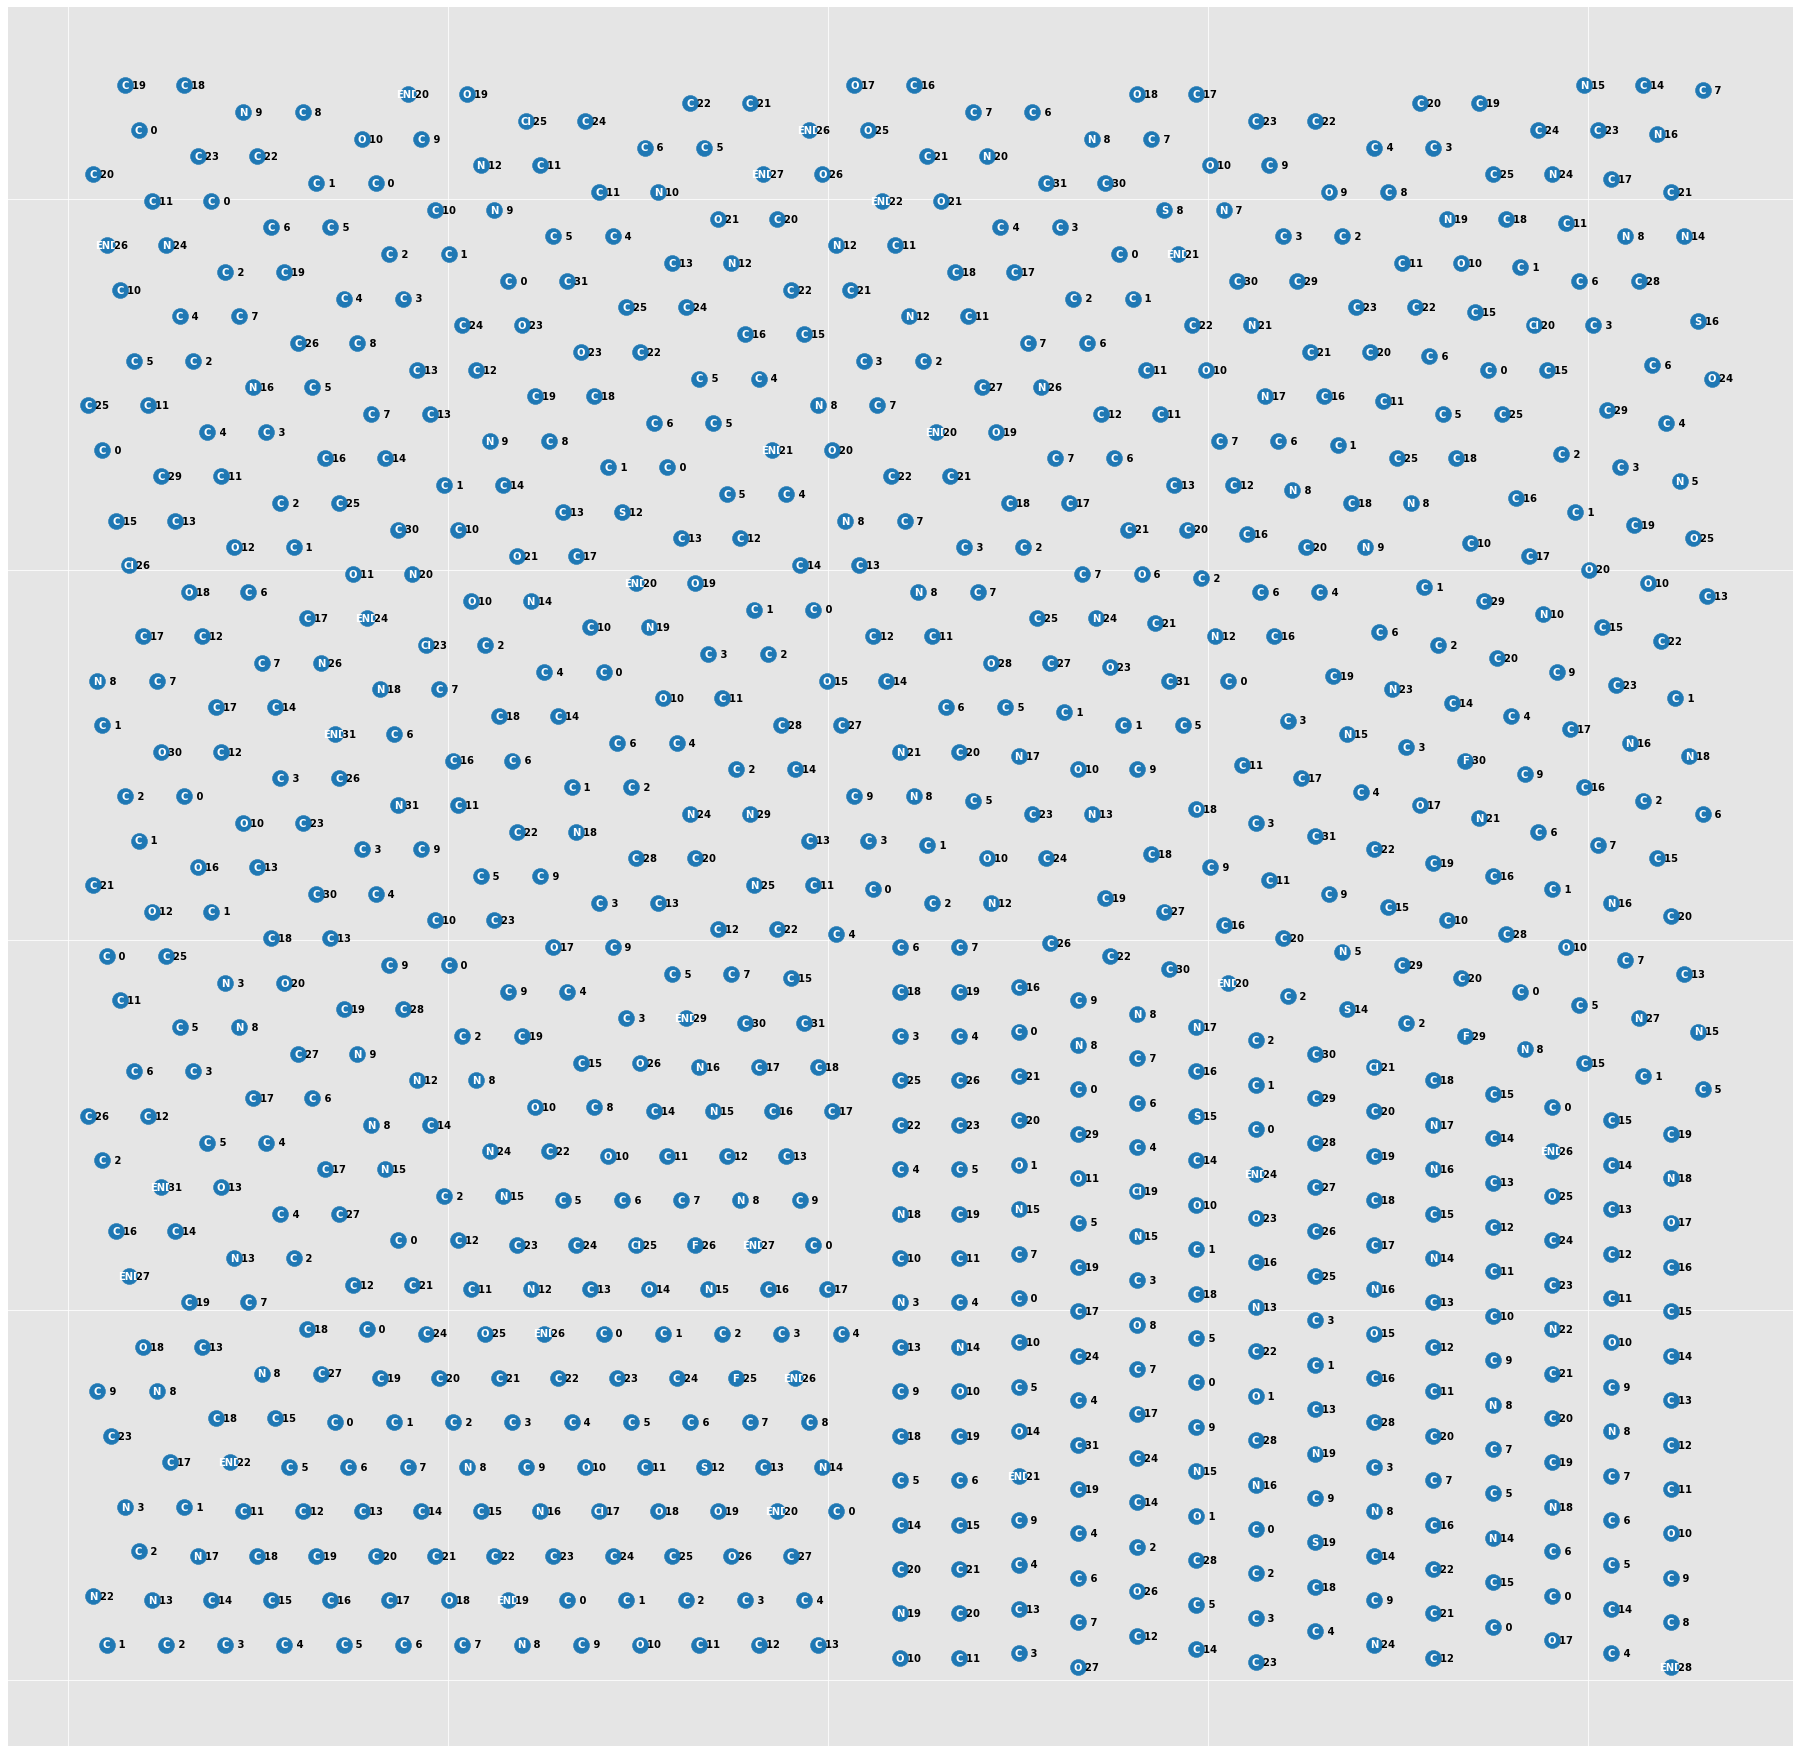

In [15]:
plt.figure(figsize=(32, 32))
run('')

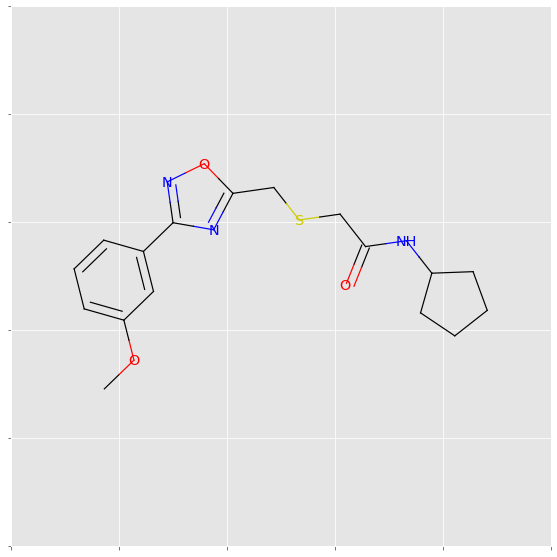

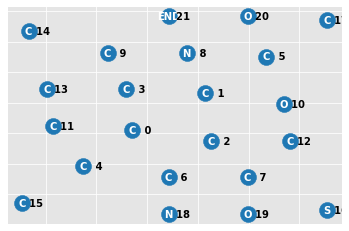

In [18]:
idx = torch.randint(len(dataset), (1,))
# idx = 4
smiles = dataset.data[idx]
mol = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(mol); plt.show()
#edge_list, node_list, emb, valid, similarity = run_network(smiles)
G = run(smiles)

In [25]:
emb_list = []
valid_list = []
sim_list = []

processed = []
for i in tqdm(range(6000)):
    while True:
        idx = torch.randint(len(dataset), (1,))
        if idx not in processed: break
    processed.append(idx)
    smiles = dataset.data[idx]
    emb, valid, similarity = run_network(smiles, draw=False)
    emb_list.append(emb.data.cpu().numpy())
    valid_list.append(valid)
    sim_list.append(similarity)

  0%|          | 0/6000 [00:00<?, ?it/s]


NameError: name 'run_network' is not defined

In [ ]:
tsne = TSNE(n_components=2, random_state=10)
emb_2d = tsne.fit_transform(emb_list)

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=valid_list, s=20, cmap='RdBu', alpha=0.7)
plt.colorbar()

plt.subplot(122)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=sim_list, s=20, alpha=0.7)
plt.colorbar()
plt.show()

plt.show()

In [ ]:
predicted = nx.Graph()
for i, n in enumerate(node_list):
    predicted.add_node(i, atom=n)
for e, bt in edge_list:
    predicted.add_edge(*e, bond_type=bt)
    
plt.figure()
plt.title(len(node_list))
#pos = nx.spring_layout(predicted)
pos = nx.kamada_kawai_layout(predicted)
nx.draw(predicted, pos)
node_labels = nx.get_node_attributes(predicted, 'atom')
nx.draw_networkx_labels(predicted, pos, labels=node_labels)
edge_labels = nx.get_edge_attributes(predicted, 'bond_type')
nx.draw_networkx_edge_labels(predicted, pos, edge_labels=edge_labels)
plt.show()

In [ ]:
mol